In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import linprog

plt.style.use('seaborn-white')
# plt.xkcd()
# print plt.style.available
%matplotlib inline

## Lending Club Minimization Problem

I recently looked into investing with LendingClub, an online peer-to-peer lender
and thought that would make a fitting cost minimization example. LendingClub
offers investors a chance to invest in notes with grades based on risk from A
through G, where an A note carries the lowest risk and pays the lowest interest
rate.

 

I want to earn at least \$100 in interest per month, while investing in three
times as many *B* notes as *A* notes, with no notes of lower grades. Investing
in notes of \$25 each, the total portfolio mix should add up to at least
\$2,800. Also, I want to invest in least 10 notes of each grade.

 

While *A* notes pay \$1.50 interest per note per month, *B* notes pay \$3.50 per
note per month. The expected cost of borrowers defaulting on A notes is \$0.50,
while B notes have an expected cost of default of \$1.00.

 

How many notes do I have to buy to minimize my cost of defaulted notes?

 

| Cost of Default:  | 0.50x + 1.00y = z      |
|-------------------|------------------------|
| Interest/Month:   | 1.5x + 3.5y \>= 100    |
| Portfolio Mix:    | 3\*25x + 25y \>= 2,800 |
|                   | x \>= 10               |
|                   | y \>= 10               |

 

 


In [20]:
# z = Cost of Default
# Minimize: z = .5*x[0] + 1.00*x[1]
# Subject to: 
# interest payment
# 1.5*x[0] + 3.5*x[1] >= 100
# 75*x[0] + 25*x[1] >= 2800
# x[0] >= 10
# x[1] >= 10

note_value = 25
min_number_of_notes = 10.0
a_loss = .5 
b_loss = 1.0

a_int_pmt = 1.5
b_int_pmt = 3.5

a_factor = 3
min_interest_pmt = 100.0
min_total_notes = 2800.0

## Linear System
We'll use sympy to solve our linear system to find the intersection of our two constraint functions. Later we'll try a couple of more options using Python below.

In [4]:
from sympy import Matrix 
M = Matrix([
        [a_int_pmt, b_int_pmt, min_interest_pmt], 
        [a_factor*note_value,note_value,min_total_notes]
        ])
R = M.rref()[0]

x = R.row(0)[2]
y = R.row(1)[2]

print 'x:', x, 'y:', y
x_r = round(x, 0)
y_r = round(y, 0)
print 'x:', x_r, 'y:', y_r

x: 32.4444444444444 y: 14.6666666666667
x: 32.0 y: 15.0


So, now that we have our x & y, we can use that to calculate some relevant metrics:

In [5]:
z = a_loss*x + b_loss*y
print 'Minimum Default Cost (z):', z

z_int = a_loss*x_r + b_loss*y_r
print 'Minimum Default Cost (z):', z_int

i = a_int_pmt*x_r + b_int_pmt*y_r
print 'Expected interest(i):', i

Minimum Default Cost (z): 30.8888888888889
Minimum Default Cost (z): 31.0
Expected interest(i): 100.5


## Graphical Solution
Let's graph to see if our solution also makes sense visually.

corner points [(10, 1000), (10, 82.0), (32.4444444444444, 14.6666666666667), (43.333333333333336, 10), (1000, 10)]


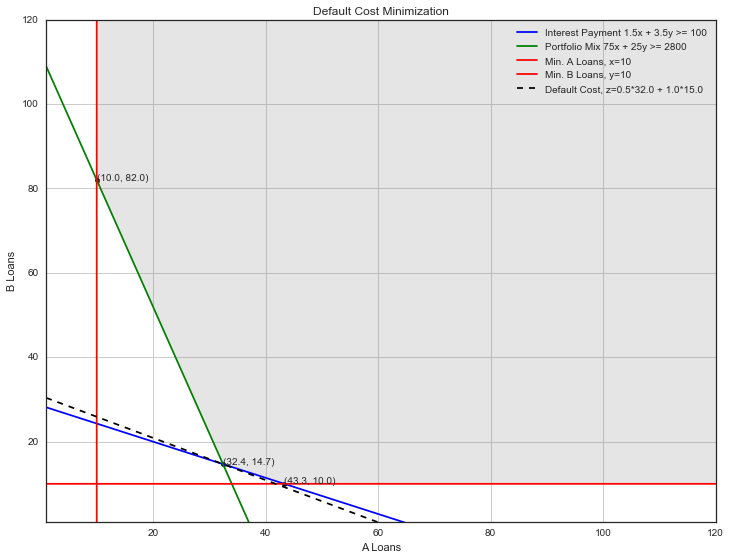

In [6]:
min_value = 1
max_value = 120

x_values = np.arange(min_value,max_value + 0.1,0.1)
y_values = np.arange(min_value,max_value + 0.1,0.1)

x0 = min_number_of_notes+0.0*y_values
y0 = min_number_of_notes+0.0*x_values

y1 = (min_interest_pmt/b_int_pmt) - (a_int_pmt/b_int_pmt)*x_values
y2 = min_total_notes/note_value - a_factor*x_values
y3 = (z - a_loss*x_values)/(b_loss)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1,1,1)

plt.xlim(min_value,max_value)
plt.ylim(min_value,max_value)
plt.hlines(0,min_value,max_value,color='k')
plt.vlines(0,min_value,max_value,color='k')
plt.grid(True)

plt.title('Default Cost Minimization')
plt.xlabel('A Loans')
plt.ylabel('B Loans')

plt.plot(x_values, y1, color='b', label='Interest Payment 1.5x + 3.5y >= 100')
plt.plot(x_values, y2, color='g', label='Portfolio Mix 75x + 25y >= 2800')
plt.plot(x0, y_values,'r', label='Min. A Loans, x=10')
plt.plot(x_values, y0,'r', label='Min. B Loans, y=10')
plt.plot(x_values, y3,'k--', label='Default Cost, z=0.5*{0} + 1.0*{1}'.format(x_r, y_r))

plt.legend(loc='best')

c_2_y = min_total_notes/note_value - a_factor*min_number_of_notes
c_4_x = (min_interest_pmt-b_int_pmt*min_number_of_notes)/a_int_pmt

X = [10,   10,    x, c_4_x, 1000]
Y = [1000, c_2_y, y, 10,    10]
plt.scatter(X, Y, c='k')

corner_points = zip(X, Y)

for xy in corner_points[1:-1]:
    ax.annotate('(%.1f, %.1f)' % xy, xy=xy)
    
plt.fill(X,Y, color='grey', alpha=0.2)

print 'corner points', corner_points

plt.show()

In [17]:
print 'Portfolio Mix x @ y=10:\t\t', min_total_notes/note_value - a_factor*min_number_of_notes

# 75x + 25y = 2800
print 'Interest Payment x @ y=10:\t', (min_interest_pmt-a_int_pmt*min_number_of_notes)/b_int_pmt
print 'Interest Payment y @ x=10:\t', (min_interest_pmt-b_int_pmt*min_number_of_notes)/a_int_pmt

Portfolio Mix x @ y=10:		82.0
Interest Payment x @ y=10:	24.2857142857
Interest Payment y @ x=10:	43.3333333333


Let's check the value at each corner point to confirm that the value at the minimum we calculated earlier is in the fact the lowest value

In [8]:
obj = np.matrix([a_loss,b_loss])
obj = np.transpose(obj)
corners = np.matrix([X, Y])
corners = np.transpose(corners)
result = np.dot(corners,obj)
print ('Value of Objective Function at Each Corner Point:\n'), result

Value of Objective Function at Each Corner Point:
[[1005.0]
 [87.0]
 [30.8888888888889]
 [31.666666666666668]
 [510.0]]


## Calculation using minimize()

In [35]:
from scipy.optimize import minimize

w = lambda x: .5*x[0] + 1.00*x[1]

constraints = (
    {'type': 'ineq', 'fun': lambda x: 1.5*x[0] + 3.5*x[1] - 100},
    {'type': 'ineq', 'fun': lambda x: 75.0*x[0] +25.0*x[1] - 2800}
)
bnds = ((0, None), (10, None), (10, None))
res = minimize(w, (0, 0, 0), bounds=bnds, constraints=constraints)
print res
print 'fun', res['fun']
print 'x', res['x'][0]
print 'x', res['x'][1]

  status: 0
 success: True
    njev: 2
    nfev: 10
     fun: 30.888888888895117
       x: array([ 32.44444444,  14.66666667,  10.        ])
 message: 'Optimization terminated successfully.'
     jac: array([ 0.5,  1. ,  0. ,  0. ])
     nit: 2
fun 30.8888888889
x 32.4444444445
x 14.6666666667


## Calculation using PuPL

In [28]:
from pulp import * 

# # Variables 
x = pulp.LpVariable("x", 10, cat=LpContinuous) 
y = pulp.LpVariable("y", 10, cat=LpContinuous) 

prob = LpProblem("DefaultCost", LpMinimize) 

# # Objective 
prob += .5*x + 1.0*y, 'Cost'

# # Constraints 
prob += 75*x+25*y >= 2800, 'Mix' 
prob += 1.5*x+3.5*y >= 100, 'Interest'
# prob += -y+z == 7 

prob.solve(pulp.GLPK())
print 'fun', pulp.value(prob.objective)
print 'x', x.varValue
print 'y', y.varValue

fun 30.8889
x 32.4444
y 14.6667
